In [1]:
! apt-get install protobuf-compiler python-pil python-lxml python-tk
! pip install Cython
! git clone https://github.com/tensorflow/models.git

%cd /content/models/research

! protoc object_detection/protos/*.proto --python_out=.

%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

! python object_detection/builders/model_builder_test.py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.16-2~18.04).
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,688 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4 all 4.6.0-1 [67.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
### Upload do modelo treinado

# S:\DComercial\Atendimento_Cliente\Processos_Comerciais\Supervisao\DataScience\Nossos Projetos e Demandas\Estruturados\____Contagem_IP

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from zipfile import ZipFile
import os

## Modelo pré-treinado para ser subido
FILE_ID = '1gfOYXnysV9Tuj2Mc3Agc2E1REuTNVryK'
download = drive.CreateFile({'id': FILE_ID})
download.GetContentFile('/content/inference_graph.zip')

with ZipFile('/content/inference_graph.zip', 'r') as zipObj:
   zipObj.extractall('/content/')

! rm /content/inference_graph.zip

In [0]:
## Importando arquivo .config
FILE_ID = '1o9Y-7ygGbZ25MtrwAMgDn2jTj3Ebh-Ci'
download = drive.CreateFile({'id': FILE_ID})
download.GetContentFile('/content/faster_rcnn_inception_v2_pets.config')

## Importanto labelmap.pbtxt
FILE_ID = '1XDIsyf1BNw3aOpQbzcaq6QX4W1LBGdDL'
download = drive.CreateFile({'id': FILE_ID})
download.GetContentFile('/content/labelmap.pbtxt')

## Importando arial.tff (melhora a qualidade das fontes)
FILE_ID = '1N8Lvo267EhtJOUiw4duK6f98AiLgbeQR'
download = drive.CreateFile({'id': FILE_ID})
download.GetContentFile('/content/arial.ttf')

In [0]:
# Upload dos conteúdos de training/labelmap.pbtxt
os.chdir('/content')
# S:\DComercial\Atendimento_Cliente\Processos_Comerciais\Supervisao\DataScience\Nossos Projetos e Demandas\Estruturados\____Contagem_IP\TensorFlow_ObjectDetection\training
#from google.colab import files
#files.upload()

In [8]:
import shutil
import os

if not os.path.exists('/content/training'):
    os.makedirs('/content/training')

shutil.move('/content/labelmap.pbtxt', '/content/training/')
shutil.move('/content/faster_rcnn_inception_v2_pets.config', '/content/training/')

'/content/training/faster_rcnn_inception_v2_pets.config'

In [0]:
MODEL_NAME = 'inference_graph'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/labelmap.pbtxt'

In [0]:
os.chdir('/content/')

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [0]:
# This is needed to display the images.
%matplotlib inline

In [0]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
#PATH_TO_TEST_IMAGES_DIR = '/content/images/train/'
PATH_TO_TEST_IMAGES_DIR = '/content/images/experiment/'

if not os.path.exists(PATH_TO_TEST_IMAGES_DIR):
    os.makedirs(PATH_TO_TEST_IMAGES_DIR)

ListImg = [ fname for fname in os.listdir(PATH_TO_TEST_IMAGES_DIR) if fname.endswith('.jpg')]

TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR,img) for img in ListImg] 

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=10)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)  

In [0]:
# GIF
#import imageio
#images = []
#filenames = [f for f in os.listdir('/content/images/experiment/') if f.endswith('.jpg')]
#for img in filenames:
#    images.append(imageio.imread('/content/images/experiment/' + img))

#imageio.mimsave('/content/movie.gif', images)

In [20]:
! pip install selenium
# Atualiza o Ubuntu para rodar 'apt install' corretamente
! apt-get update
! apt install chromium-chromedriver
! cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

     |████████████████████████████████| 911kB 5.0MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [74.3 kB]
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:14 http://ppa.l

In [0]:
# Selenium é um framework de automação para web
import time
import datetime
import os
from PIL import Image
from selenium import webdriver
# from selenium.webdriver.chrome.options import Options

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

def get_screenshot_from_url(link):
    tempo_ini = datetime.datetime.now()
    DRIVER = 'chromedriver'
    #wd = webdriver.Chrome(DRIVER, chrome_options= chrome_options)
    # Usar options ao invés de chrome_options
    wd = webdriver.Chrome(DRIVER, options= chrome_options)
    wd.get(link)
    time.sleep(1)
    # o truque
    wd.set_window_size(1920, 1000)

    DESTIN_PATH = '/content/images/URL_Imagery/'    
    if not os.path.exists(DESTIN_PATH):
      os.makedirs(DESTIN_PATH)

    ini_string = link.index('@') + 1
    fim_string = link.index(',h')
    Meio = link[ini_string : fim_string]
    Meio = Meio.replace('.','_')
    Meio = Meio.replace(',','_')

    FULL_PATH = DESTIN_PATH + Meio + "_ScreenShot.png"
    wd.save_screenshot(FULL_PATH)
    wd.quit() 
    # Lê imagem como .PNG
    im = Image.open(FULL_PATH)
    bbox = (772, 332, 1522, 820)
    im = im.crop(bbox)
    # Converte imagem para .JPG
    im = im.convert('RGB')
    #plt.imshow(im)
    os.remove(FULL_PATH)
    FULL_PATH_JPG = DESTIN_PATH + Meio + "_ScreenShot.jpg"
    im.save(FULL_PATH_JPG)
    tempo_fim = datetime.datetime.now()
    delta_t = tempo_fim - tempo_ini
    print("Imagem encontrada e recortada em {} seg com sucesso!".format(delta_t))

In [0]:
from google.colab.patches import cv2_imshow
import cv2

def verify_black_level(img_path):
  img = cv2.imread(img_path, 0)
  # conta todos os pixels não pretos da imagem
  cntNotBlack = cv2.countNonZero(img)
  # conta todos os pixels da imagem
  height, width = img.shape
  cntPixels = height * width
  # calcula os pixels preto
  cntBlack = cntPixels - cntNotBlack
  #cv2_imshow(img)
  black_level = cntBlack/cntPixels
  return(black_level)

In [0]:
def detect_and_classify_ip(URL_IMAGERY, FLAG_SHOW= False):
  # URL_IMAGERY é uma lista que contém os caminhos das imagens
  # FLAG_SHOW é um booleano para exibir a imagem e a bbox
  for image_path in URL_IMAGERY:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=10)
    
    if FLAG_SHOW == True:
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

    THRESHOLD_BLACK = .95
    THRESHOLD_SCORE = .8
    if verify_black_level(image_path) > THRESHOLD_BLACK:
      print("Imagem indisponível no Street View")
    elif output_dict['detection_scores'][0] >= THRESHOLD_SCORE:
      print("Iluminação pública detectada no Street View com {0:.0%} de confiabilidade".format(output_dict['detection_scores'][0]))
    else: 
      print("Iluminação pública não detectada no Street View")


In [24]:
#! rm -rf '/content/images/URL_Imagery/'

url_list = ["https://www.gps-coordinates.net/street-view/@-24.2945,-47.003,h0,p20,z1",
            "https://www.gps-coordinates.net/street-view/@-24.2945,-47.003,h90,p20,z1",
            "https://www.gps-coordinates.net/street-view/@-24.2945,-47.003,h180,p20,z1",
            "https://www.gps-coordinates.net/street-view/@-24.2945,-47.003,h270,p20,z1",
            "https://www.gps-coordinates.net/street-view/@-24.2945,-46.9748,h0,p20,z1",
            "https://www.gps-coordinates.net/street-view/@-24.2945,-46.9748,h90,p20,z1",
            "https://www.gps-coordinates.net/street-view/@-24.2945,-46.9748,h180,p20,z1",
            "https://www.gps-coordinates.net/street-view/@-24.2945,-46.9748,h270,p20,z1",
            "https://www.gps-coordinates.net/street-view/@-24.2945,-46.9729,h0,p20,z1",
            "https://www.gps-coordinates.net/street-view/@-24.2945,-46.9729,h90,p20,z1"]

#for item in url_list:
#  get_screenshot_from_url(item)

Imagem encontrada e recortada em 0:00:06.559615 seg com sucesso!
Imagem encontrada e recortada em 0:00:05.459911 seg com sucesso!
Imagem encontrada e recortada em 0:00:05.450611 seg com sucesso!
Imagem encontrada e recortada em 0:00:05.463884 seg com sucesso!
Imagem encontrada e recortada em 0:00:07.448185 seg com sucesso!
Imagem encontrada e recortada em 0:00:06.458806 seg com sucesso!
Imagem encontrada e recortada em 0:00:06.450157 seg com sucesso!
Imagem encontrada e recortada em 0:00:05.433097 seg com sucesso!
Imagem encontrada e recortada em 0:00:06.448449 seg com sucesso!
Imagem encontrada e recortada em 0:00:05.482263 seg com sucesso!


### Importação da base de latitudes e longitudes

In [25]:
import pandas as pd
df = pd.read_csv('/content/PERUIBE_list_maps - Cópia.txt', sep= ";")
df.head(2)

cidade  ...                                               h270
0  PERUIBE  ...  https://www.gps-coordinates.net/street-view/@-...
1  PERUIBE  ...  https://www.gps-coordinates.net/street-view/@-...

[2 rows x 6 columns]

In [36]:
url_list = list(df['h0'])
! rm -rf '/content/images/URL_Imagery/'

for i, item in enumerate(url_list, 1):
  print('{}/{}'.format(i, len(url_list)))
  get_screenshot_from_url(item)

1/76
Imagem encontrada e recortada em 0:00:04.071120 seg com sucesso!
2/76
Imagem encontrada e recortada em 0:00:05.592386 seg com sucesso!
3/76
Imagem encontrada e recortada em 0:00:03.664556 seg com sucesso!
4/76
Imagem encontrada e recortada em 0:00:03.775836 seg com sucesso!
5/76
Imagem encontrada e recortada em 0:00:04.759708 seg com sucesso!
6/76
Imagem encontrada e recortada em 0:00:03.754617 seg com sucesso!
7/76
Imagem encontrada e recortada em 0:00:04.006714 seg com sucesso!
8/76
Imagem encontrada e recortada em 0:00:04.151905 seg com sucesso!
9/76
Imagem encontrada e recortada em 0:00:03.856813 seg com sucesso!
10/76
Imagem encontrada e recortada em 0:00:04.919025 seg com sucesso!
11/76
Imagem encontrada e recortada em 0:00:04.352621 seg com sucesso!
12/76
Imagem encontrada e recortada em 0:00:03.695946 seg com sucesso!
13/76
Imagem encontrada e recortada em 0:00:04.712606 seg com sucesso!
14/76
Imagem encontrada e recortada em 0:00:05.191549 seg com sucesso!
15/76
Imagem en

In [43]:
PATH_TO_TEST_IMAGES_DIR = '/content/images/URL_Imagery/'
ListImg = [ fname for fname in os.listdir(PATH_TO_TEST_IMAGES_DIR) if fname.endswith('.jpg')]
URL_IMAGERY = [ os.path.join(PATH_TO_TEST_IMAGES_DIR,img) for img in ListImg] 

detect_and_classify_ip(URL_IMAGERY)

Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Iluminação pública não detectada no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Iluminação pública não detectada no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Iluminação pública detectada 

Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Iluminação pública não detectada no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Iluminação pública não detectada no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Iluminação pública detectada no Street View com 100% de confiabilidade
Imagem indisponível no Street View
Imagem indisponível no Street View
Iluminação pública detectada no Street View com 92% de confiabilidade
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível no Street View
Imagem indisponível

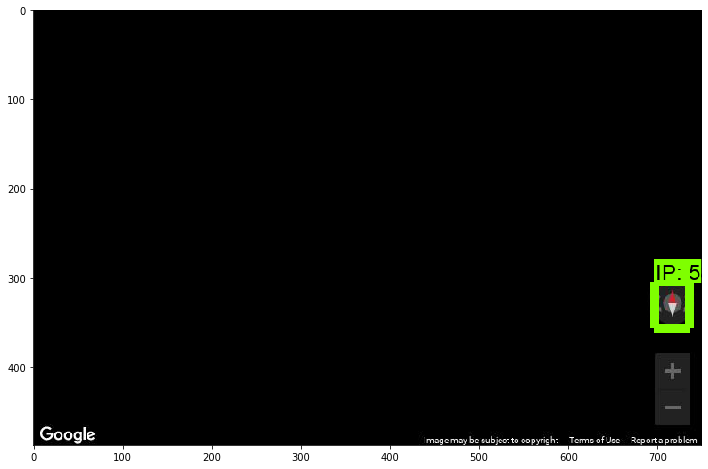

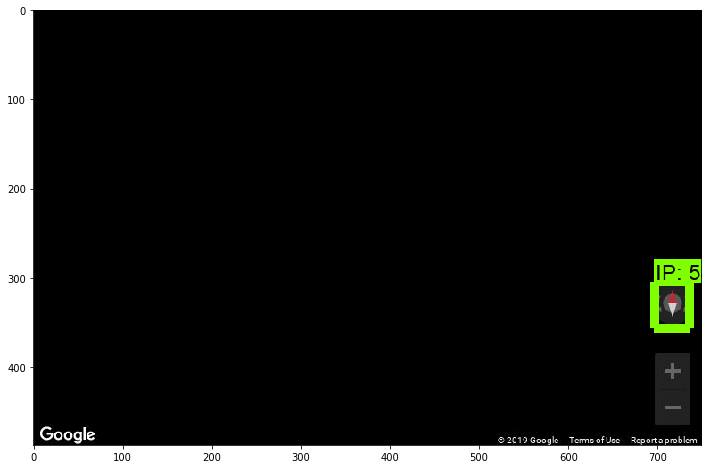

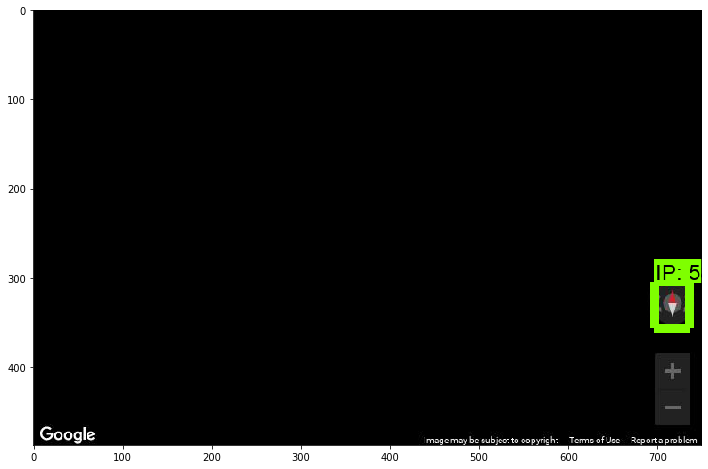

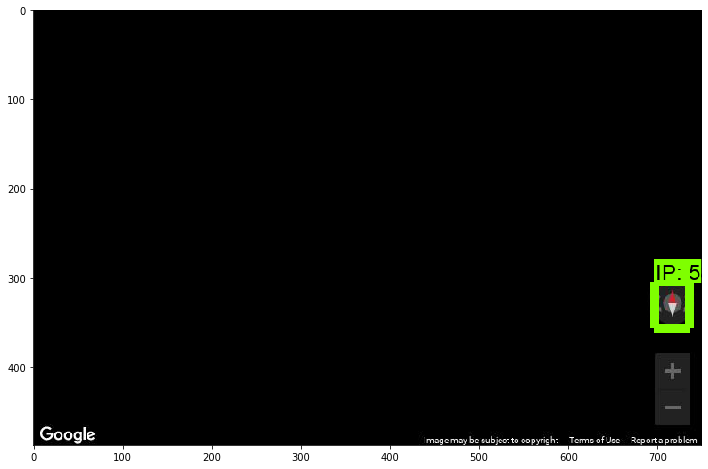

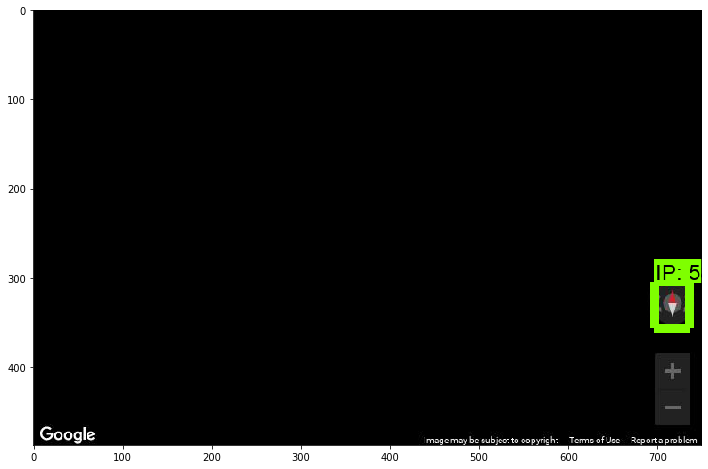

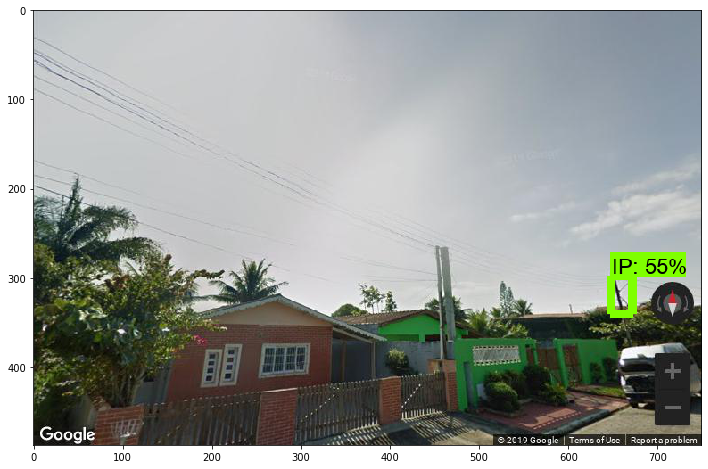

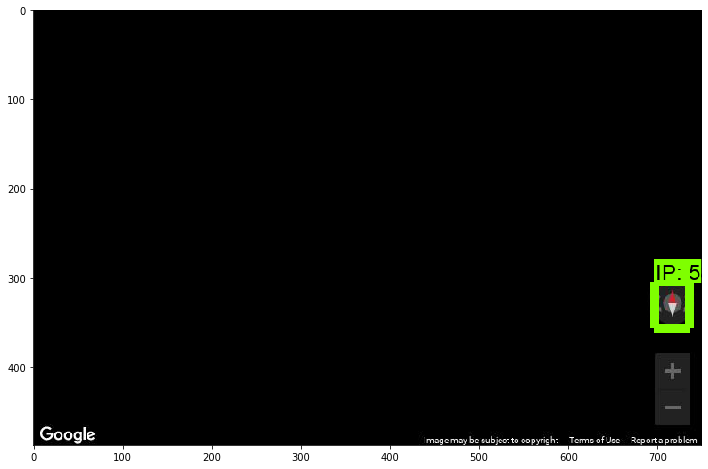

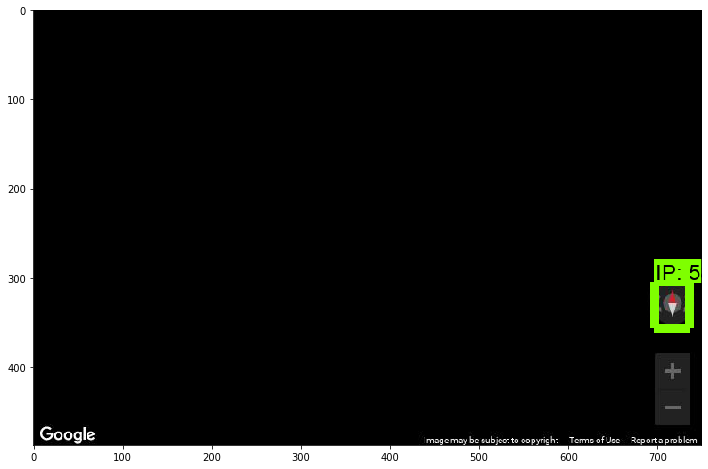

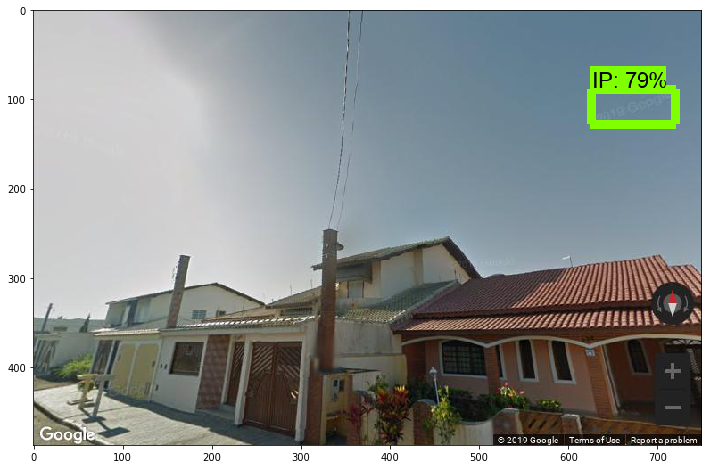

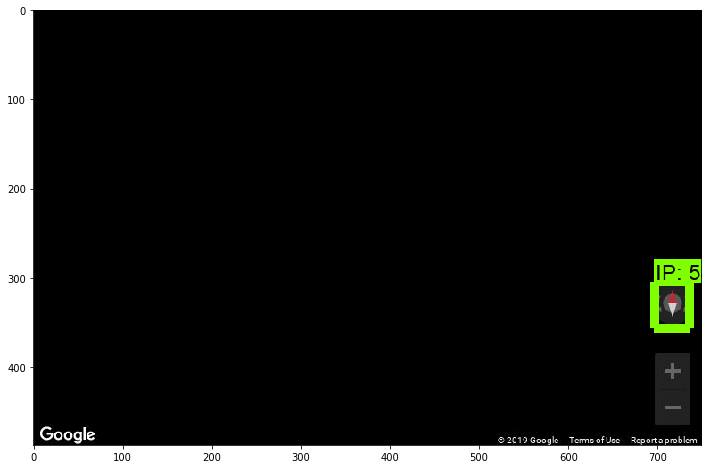

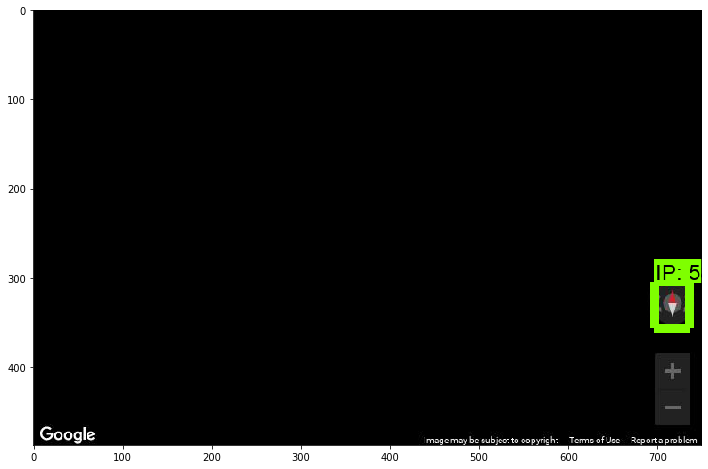

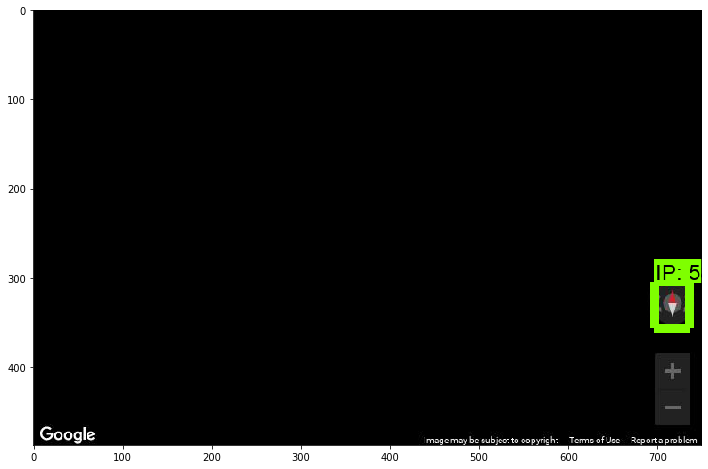

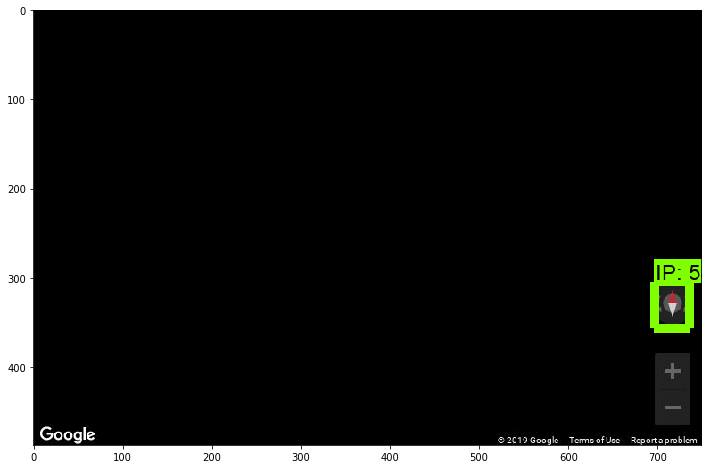

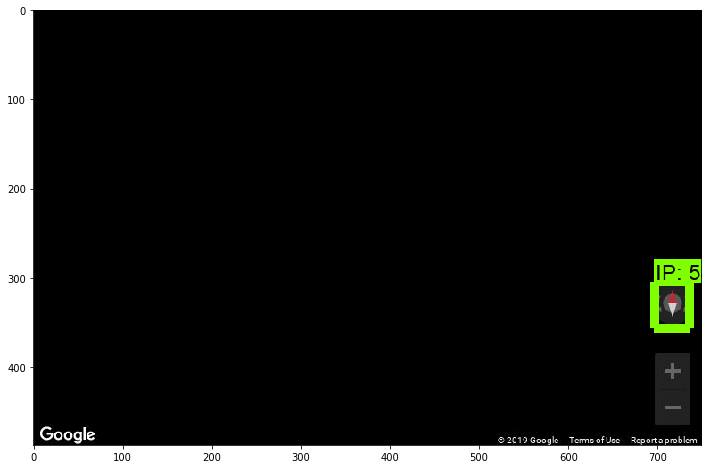

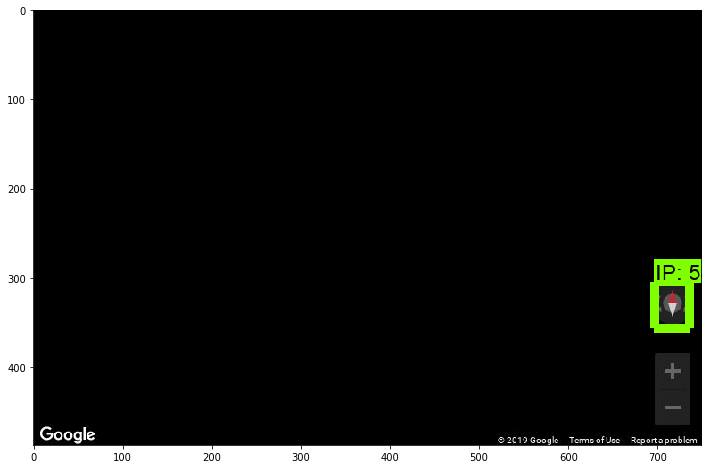

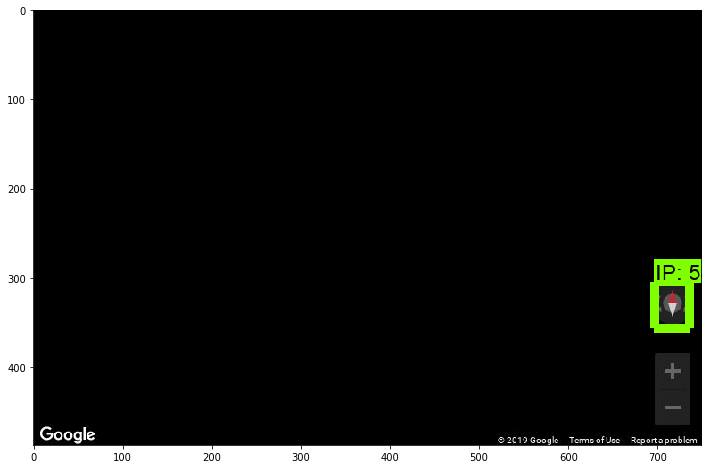

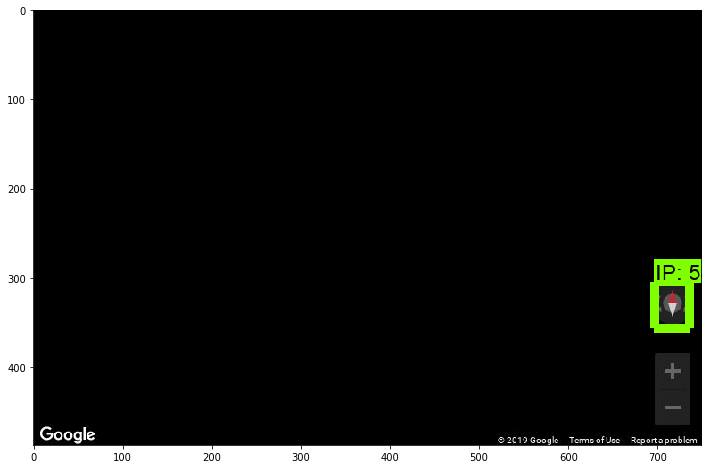

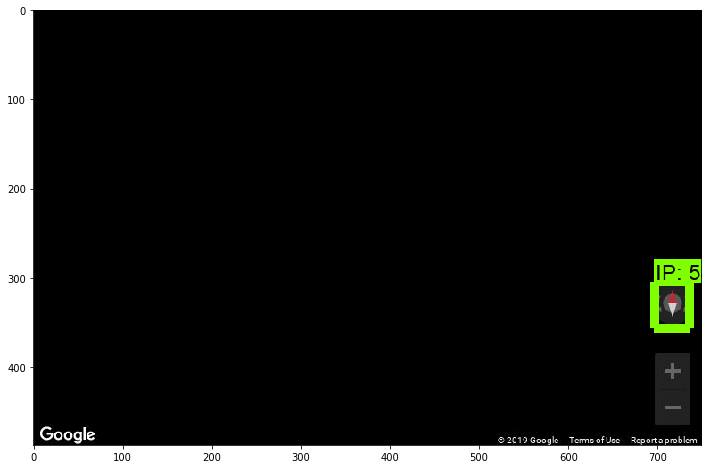

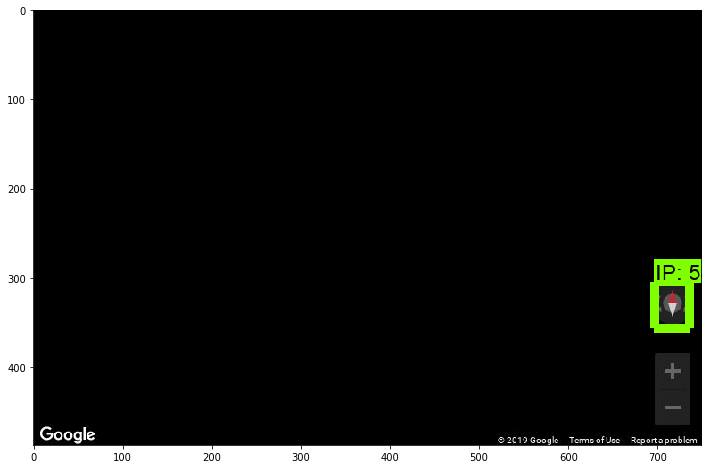

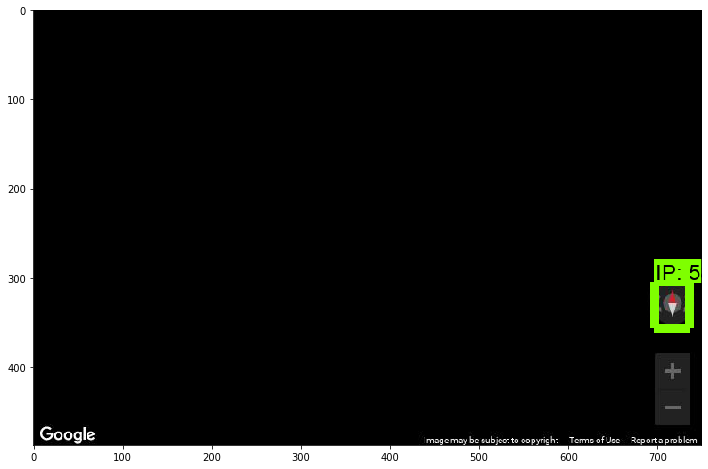

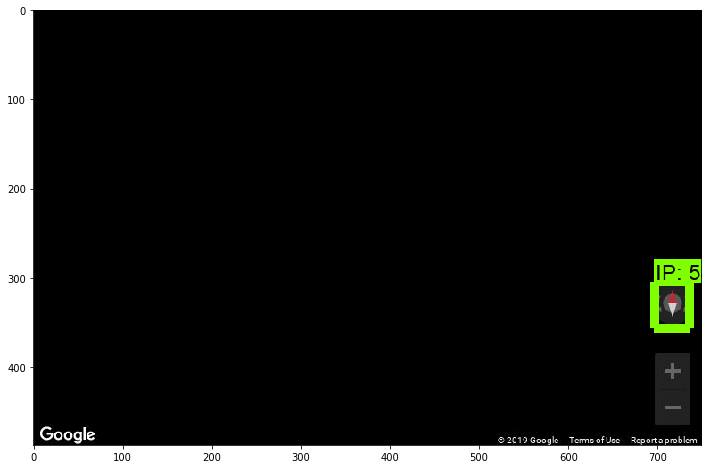

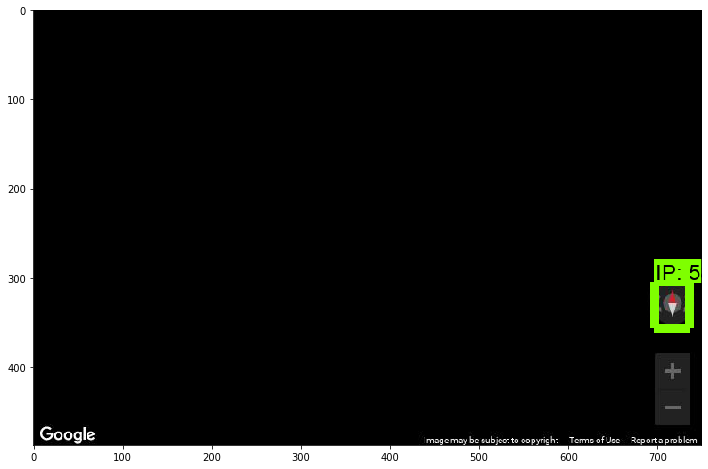

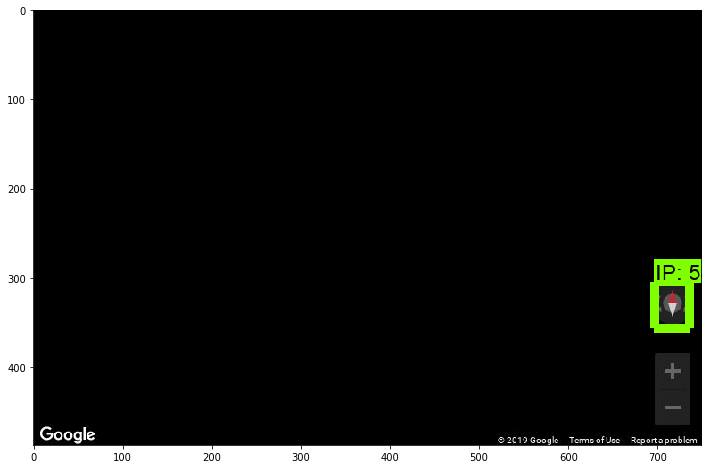

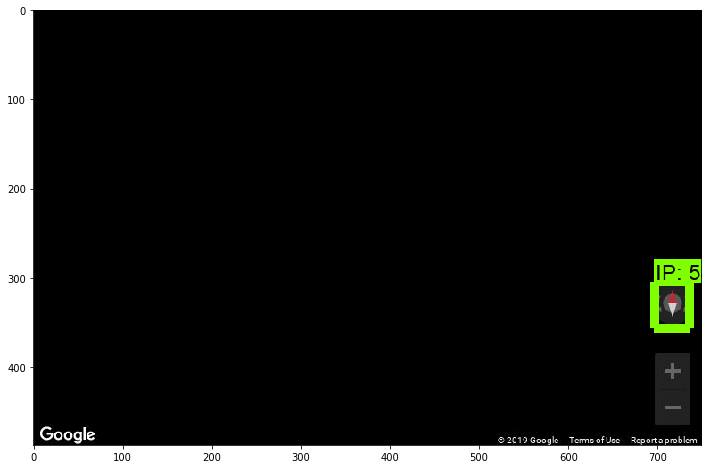

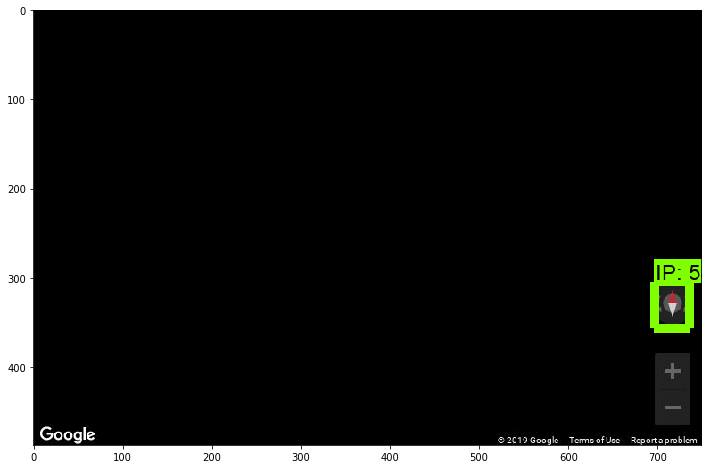

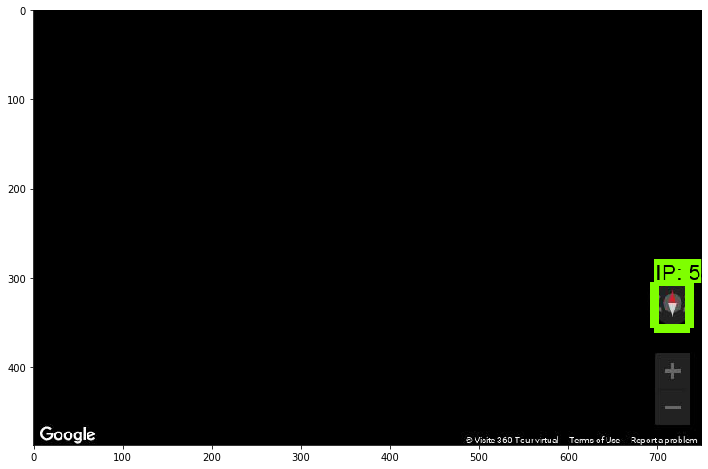

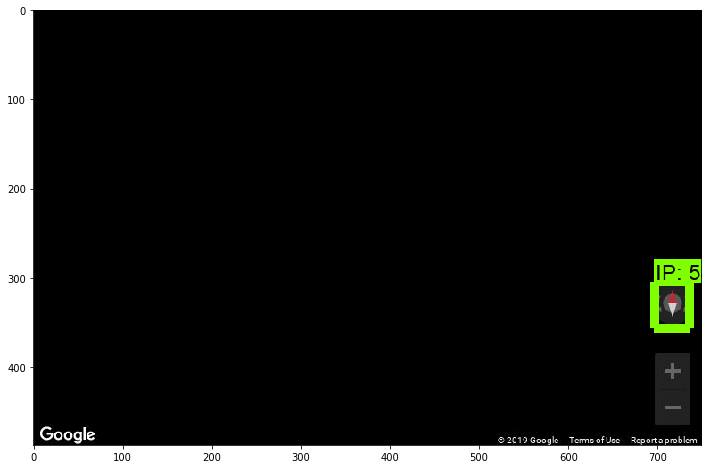

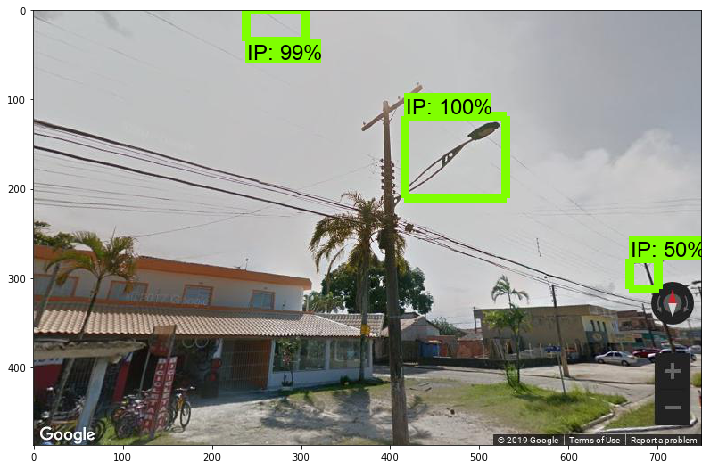

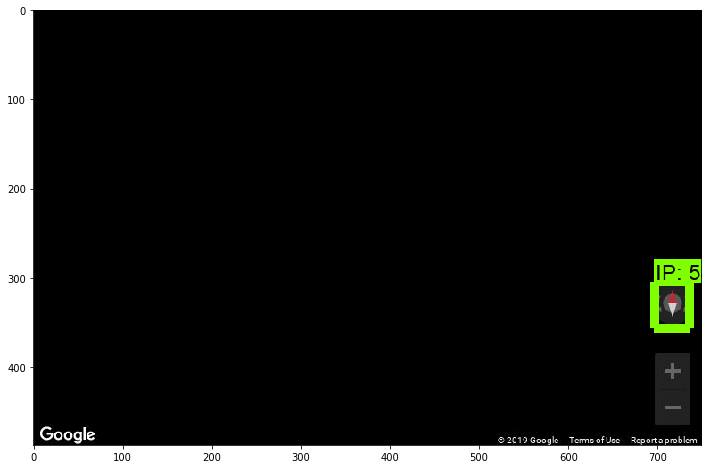

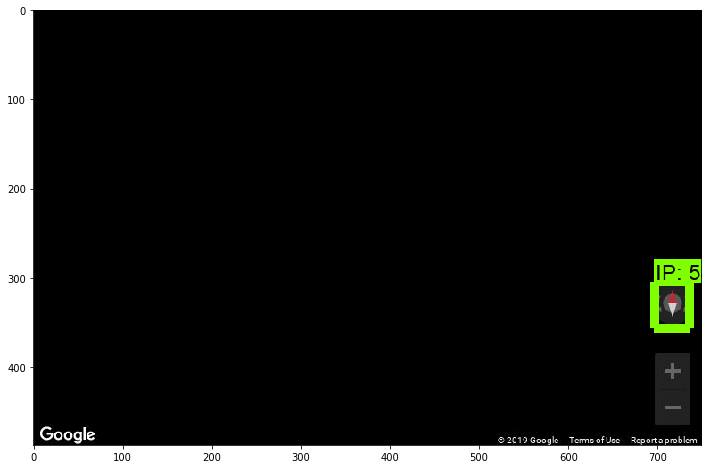

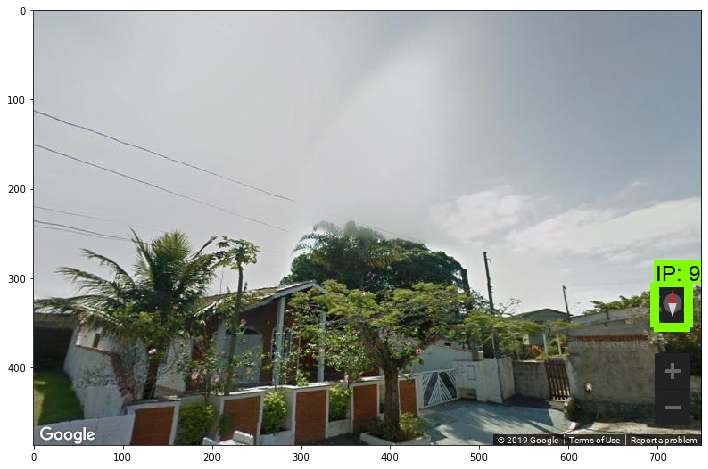

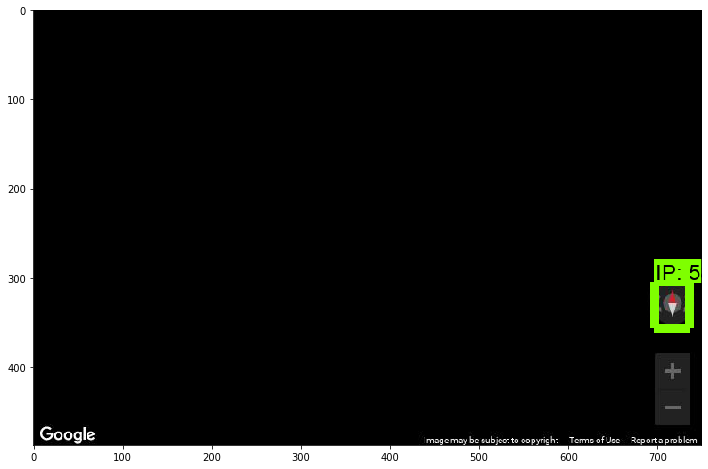

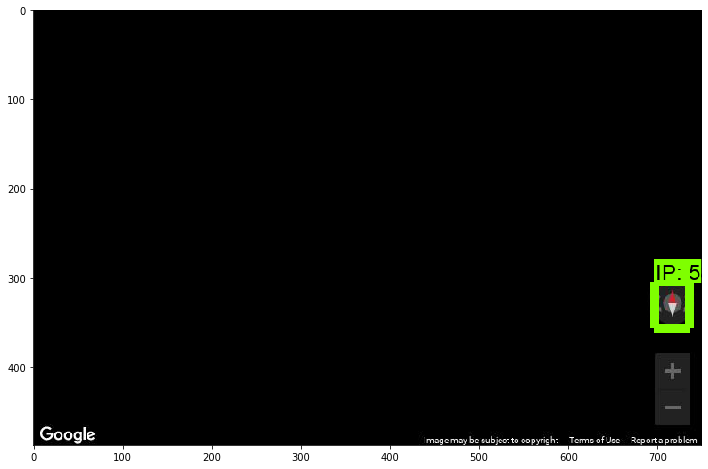

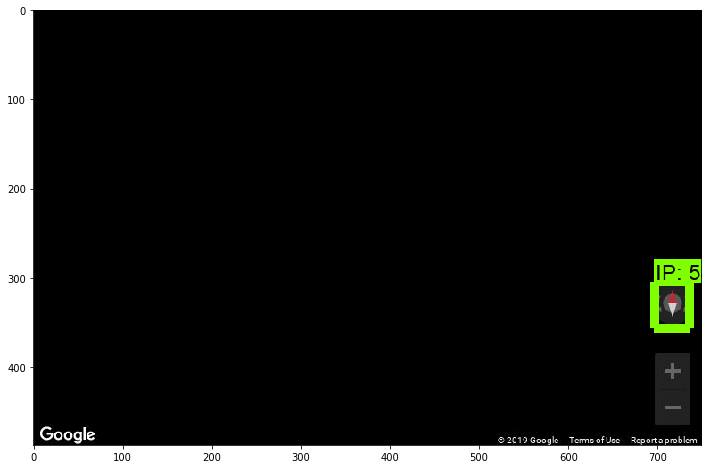

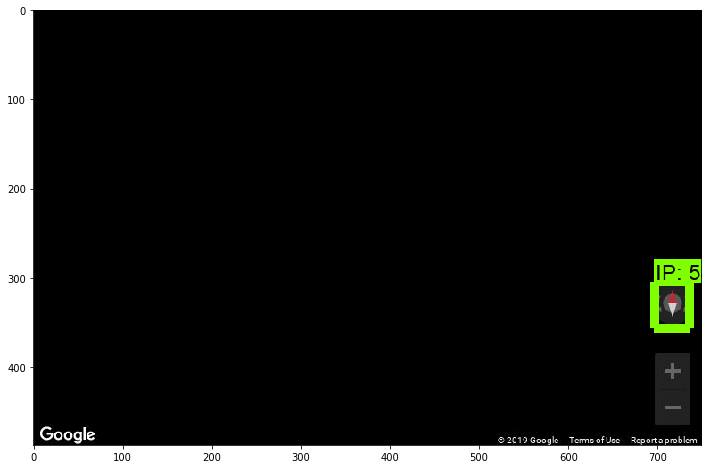

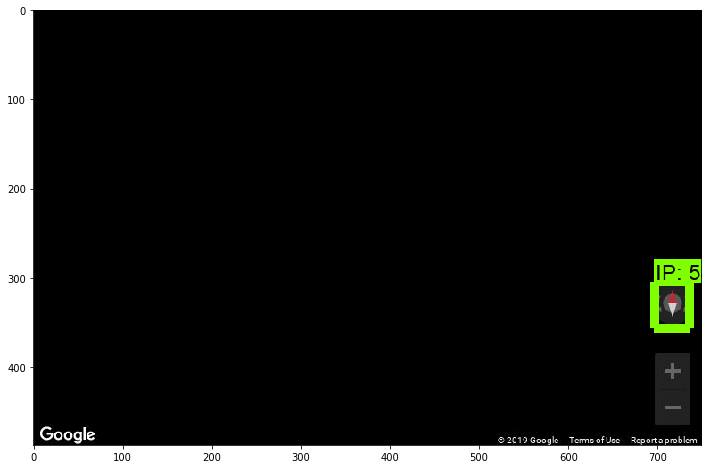

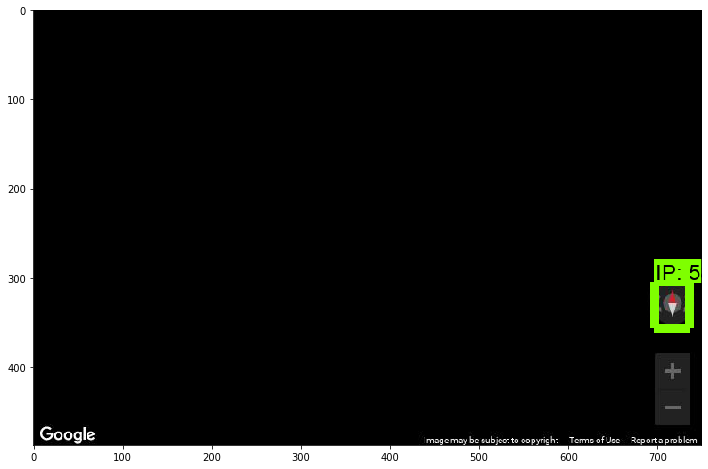

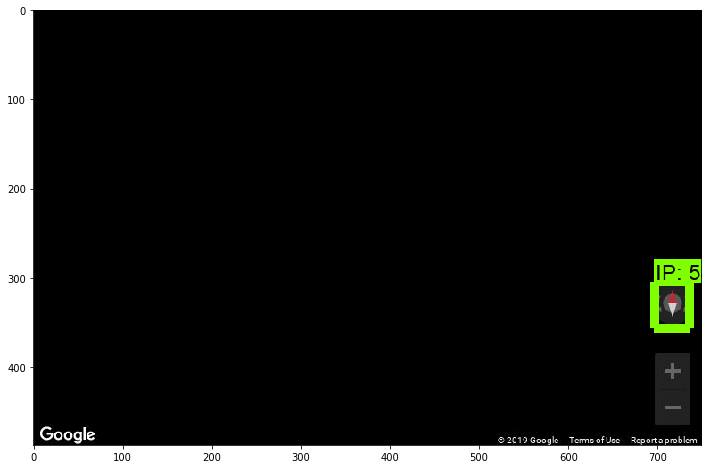

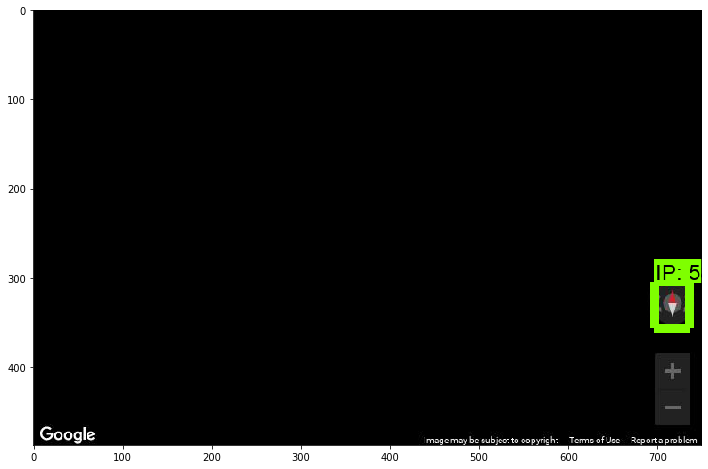

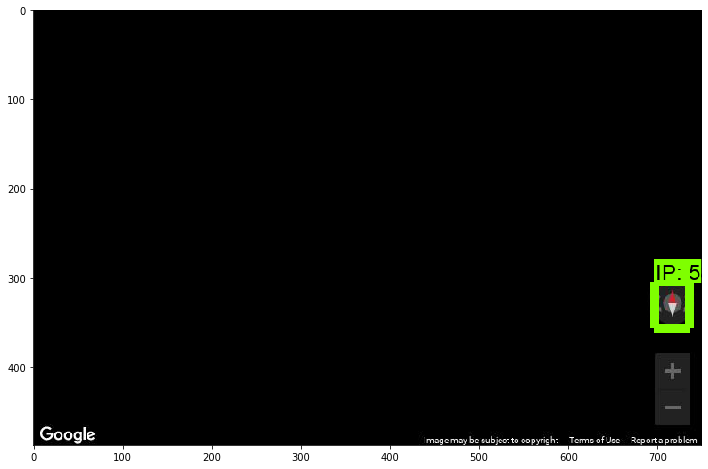

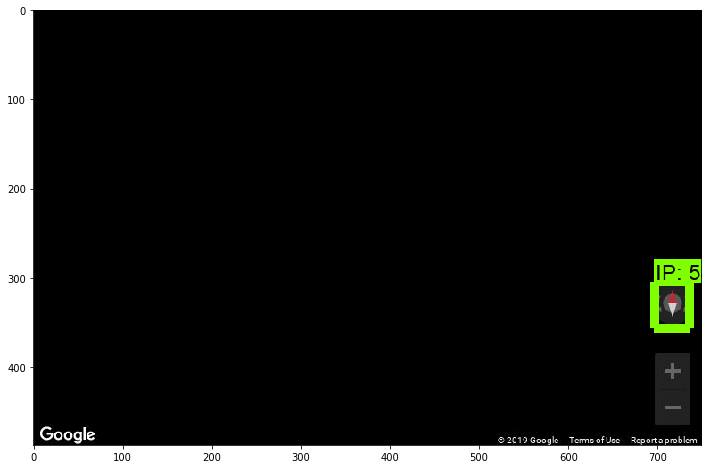

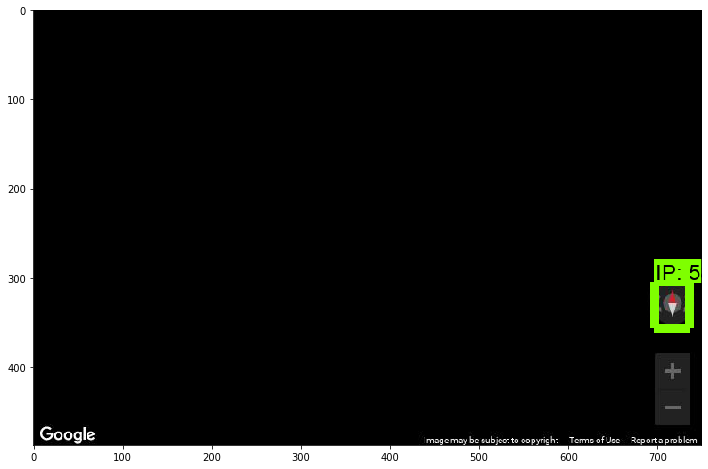

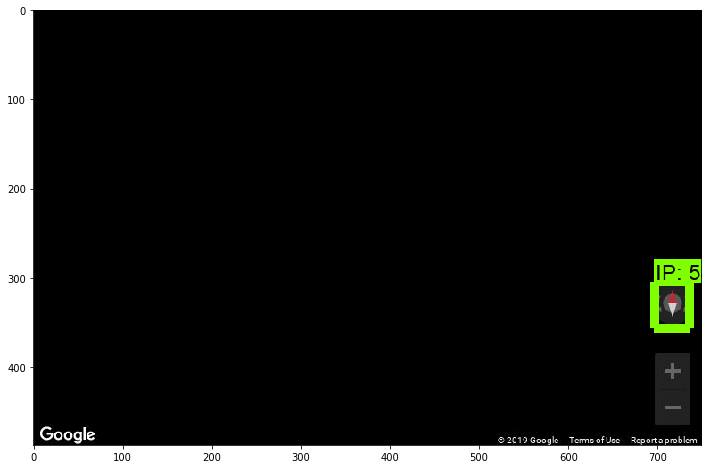

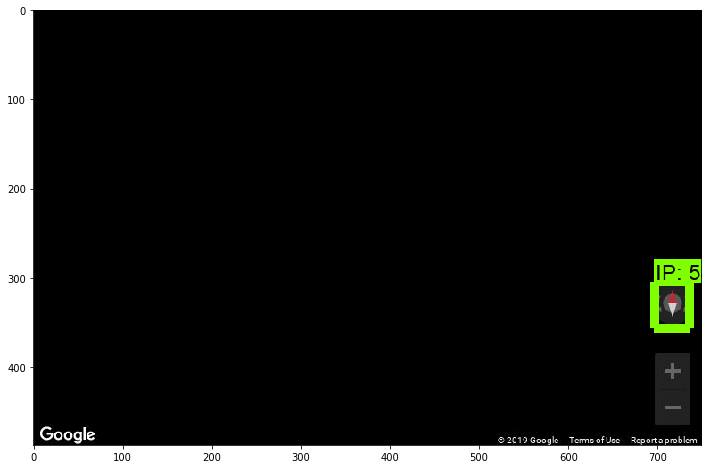

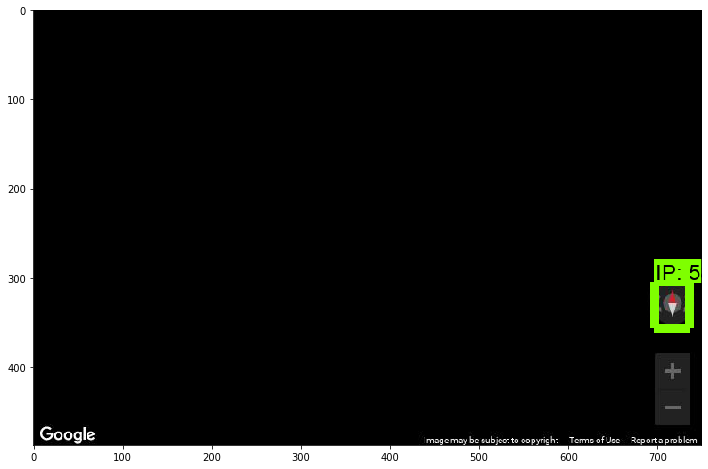

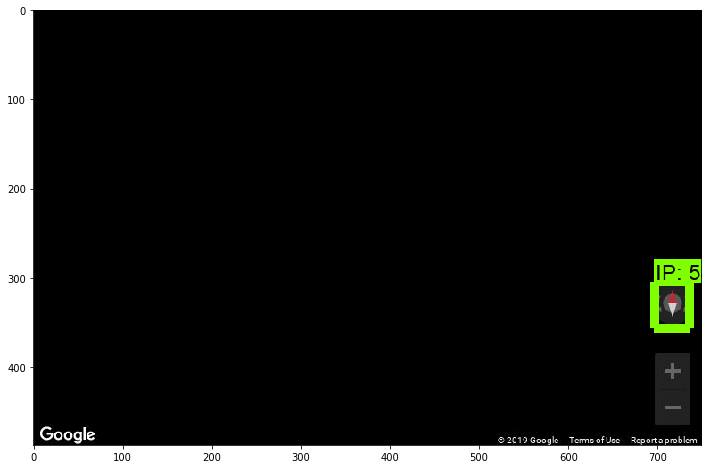

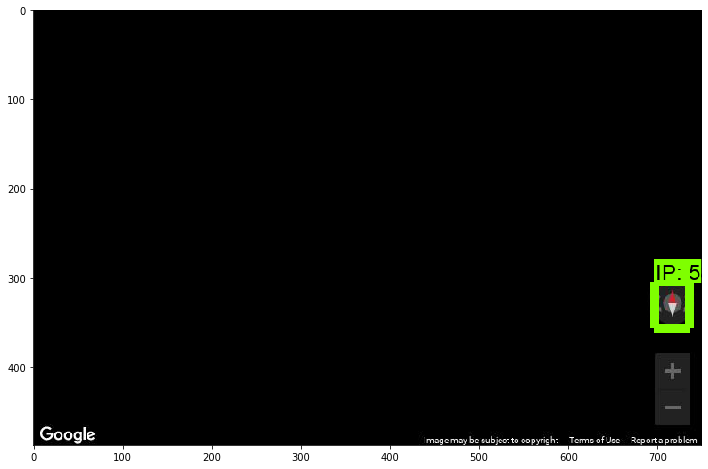

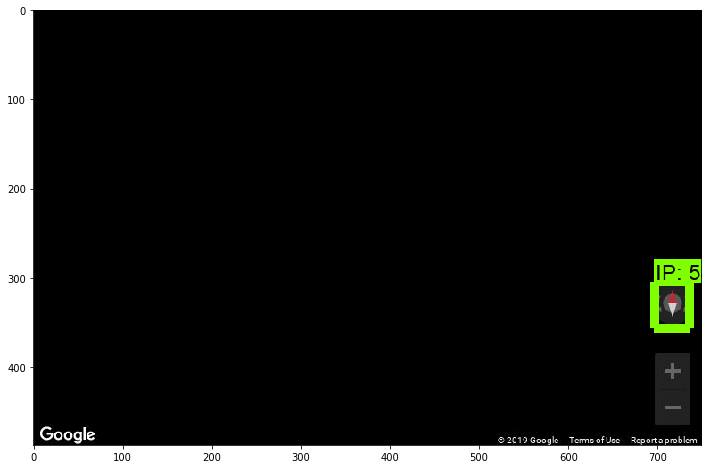

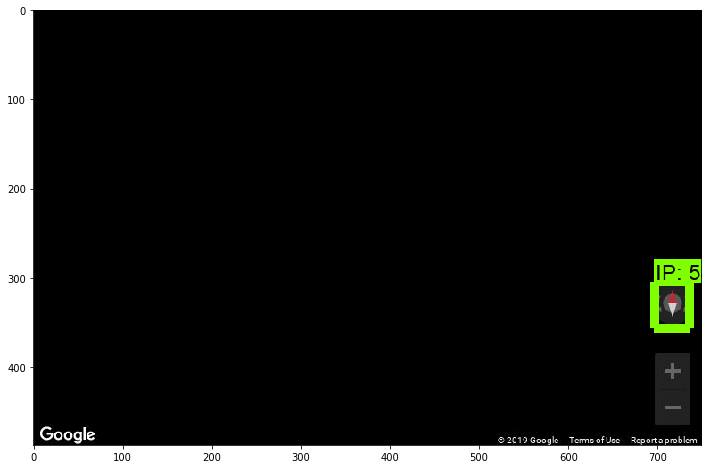

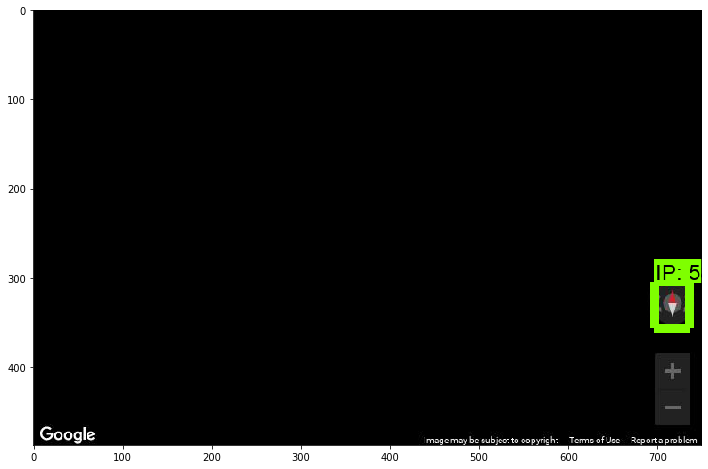

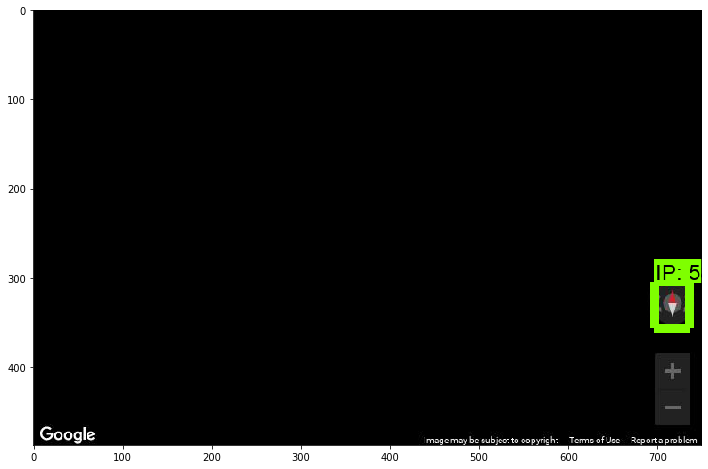

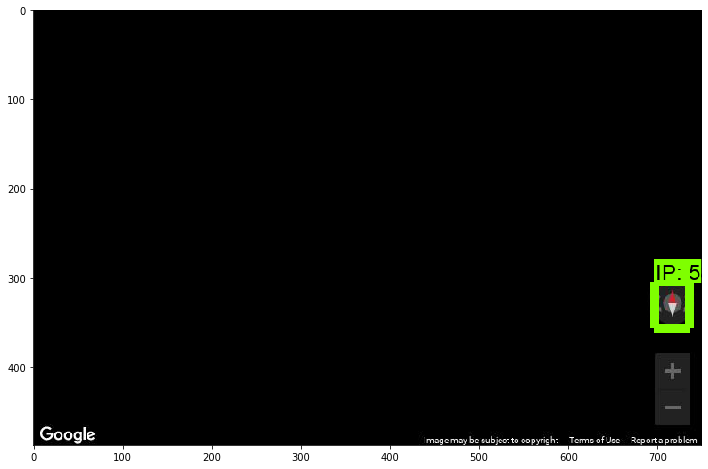

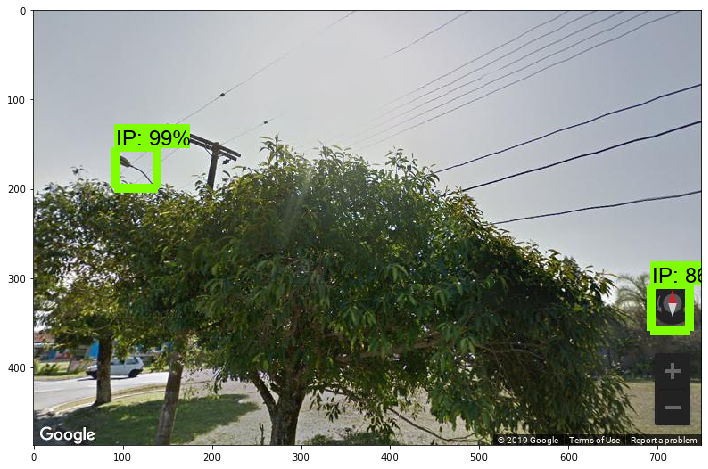

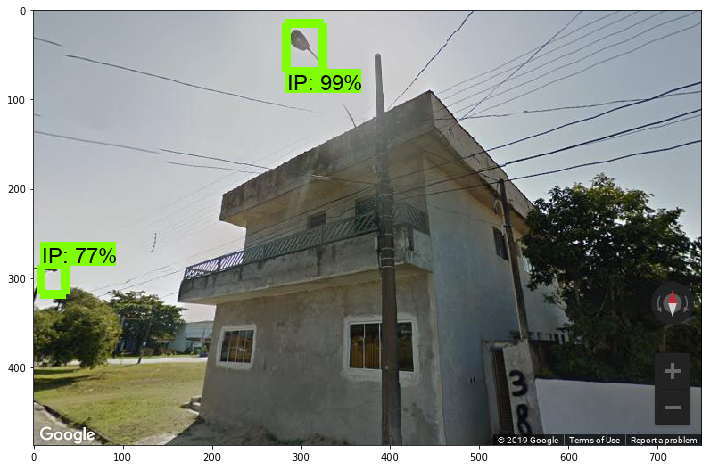

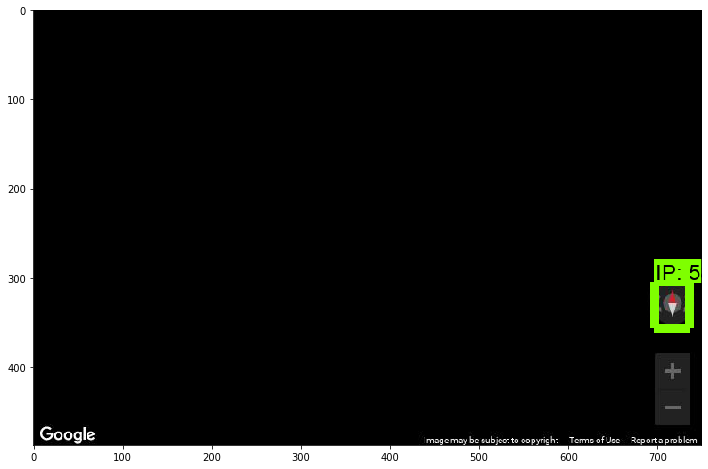

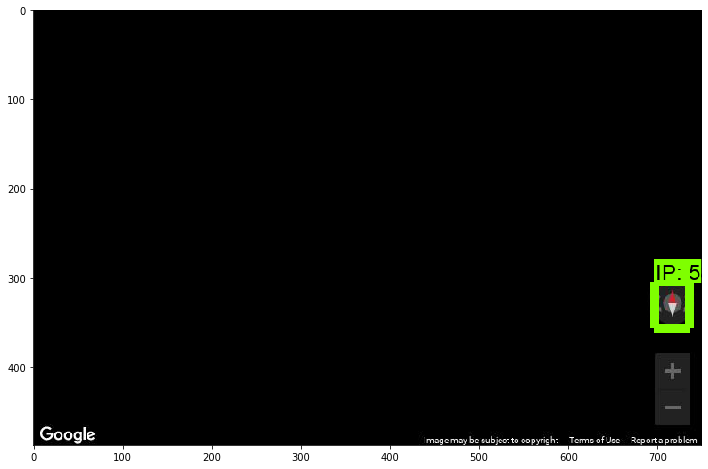

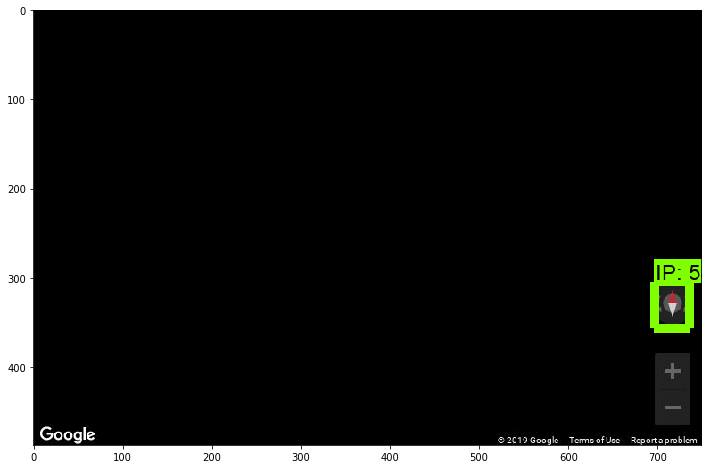

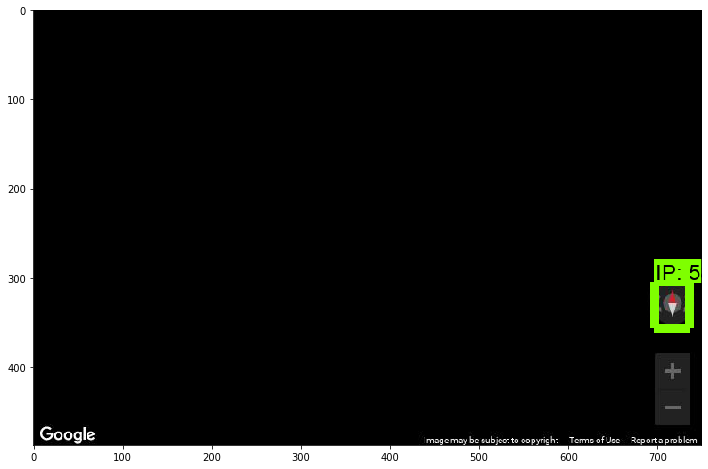

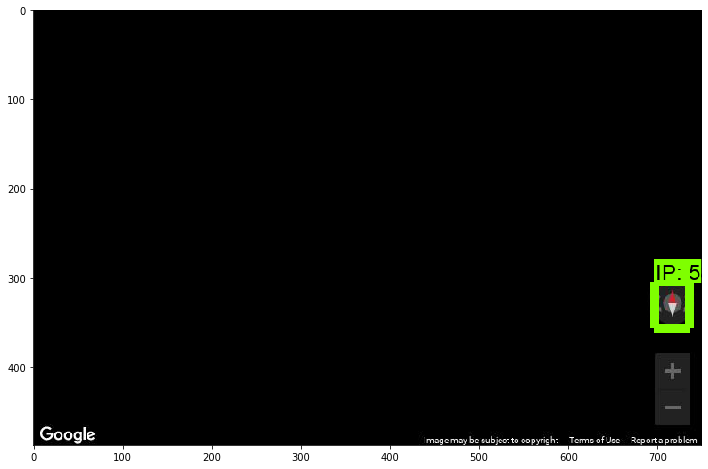

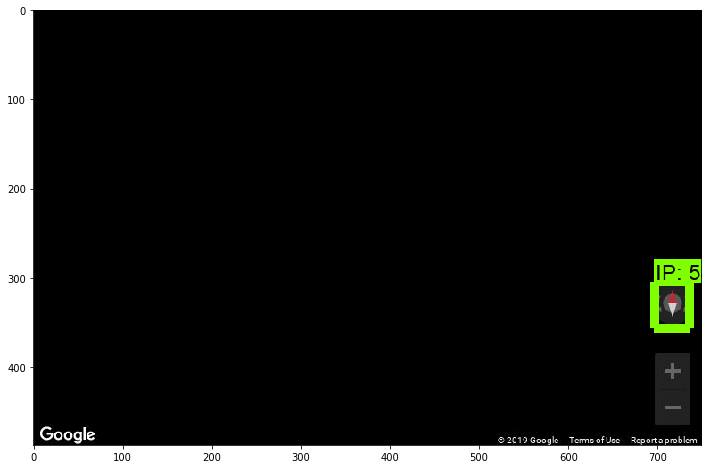

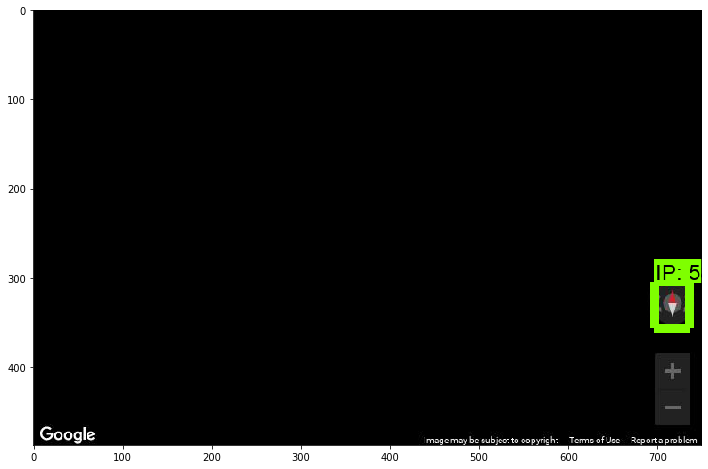

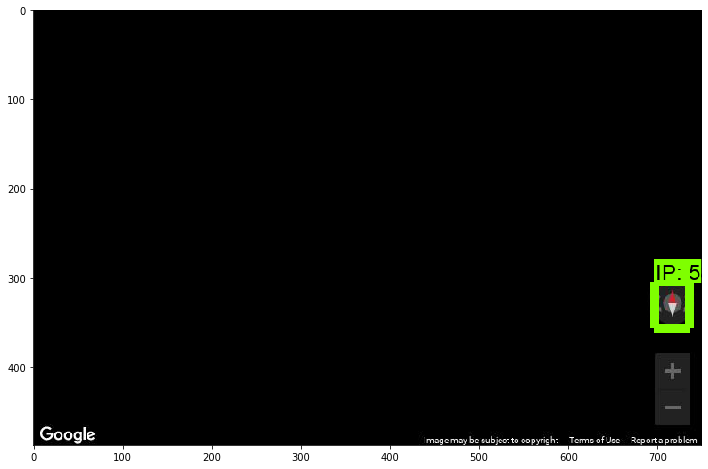

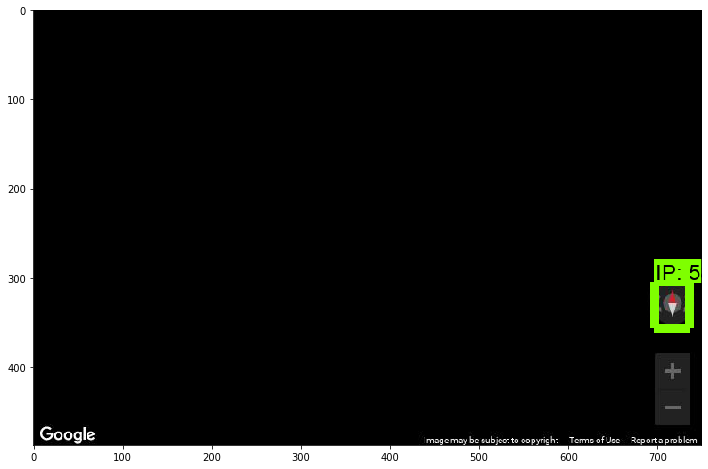

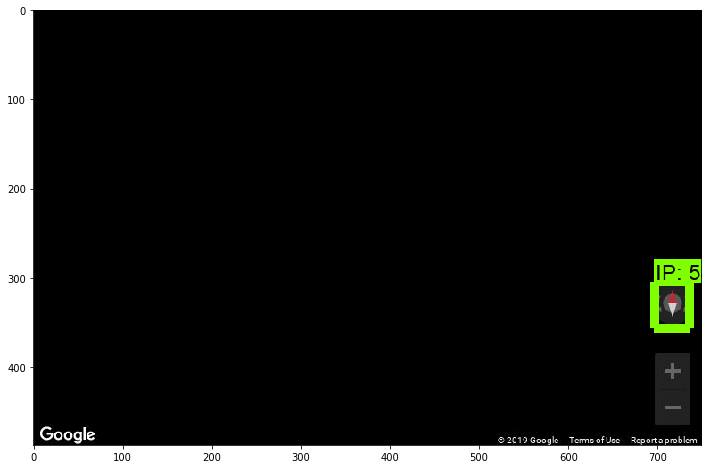

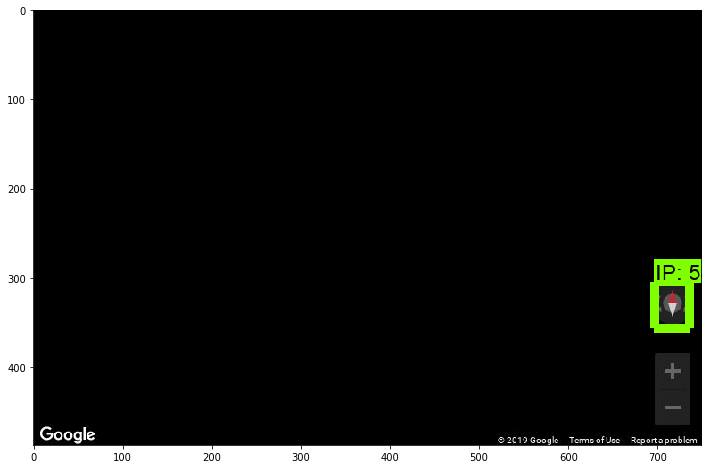

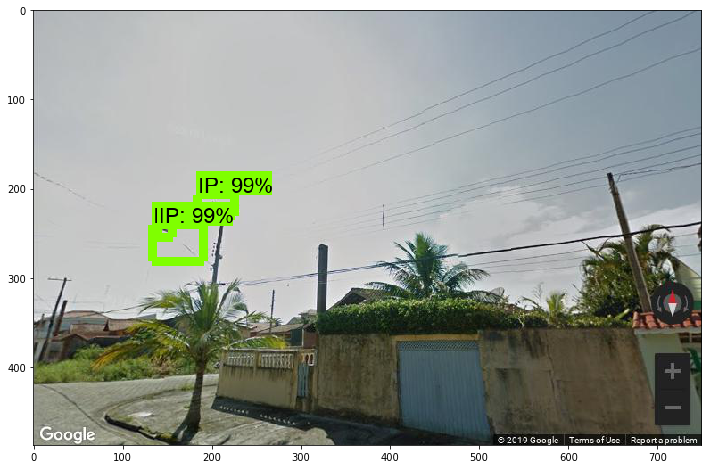

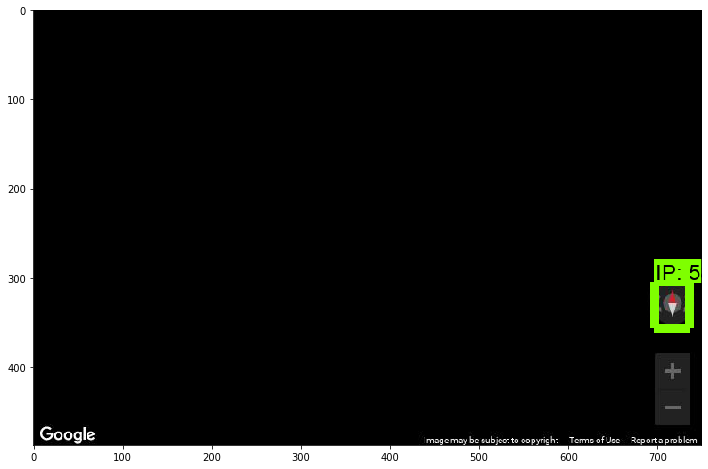

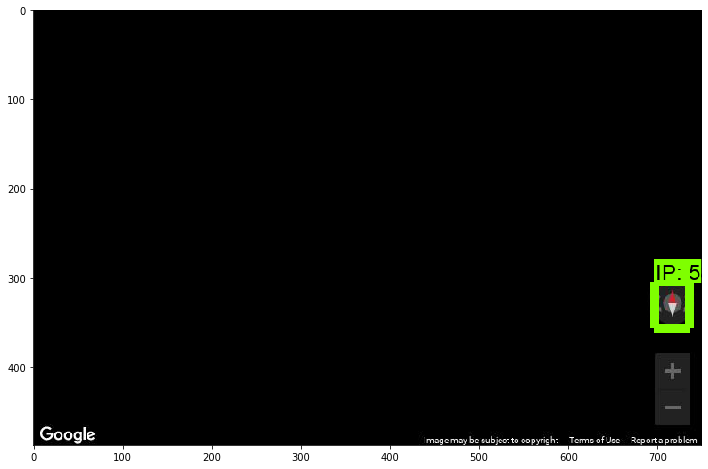

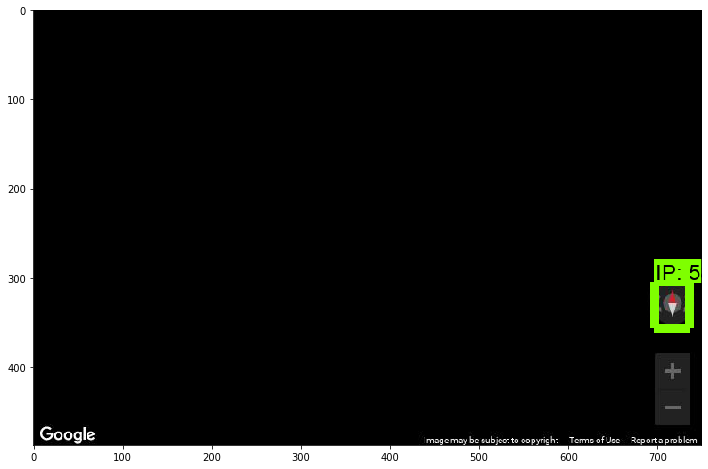

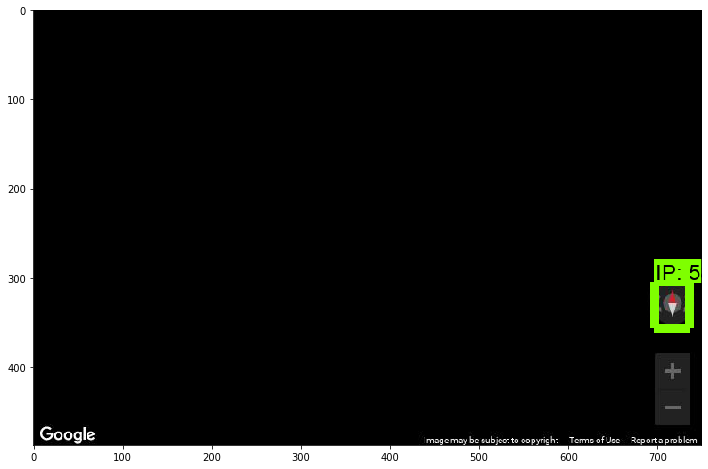

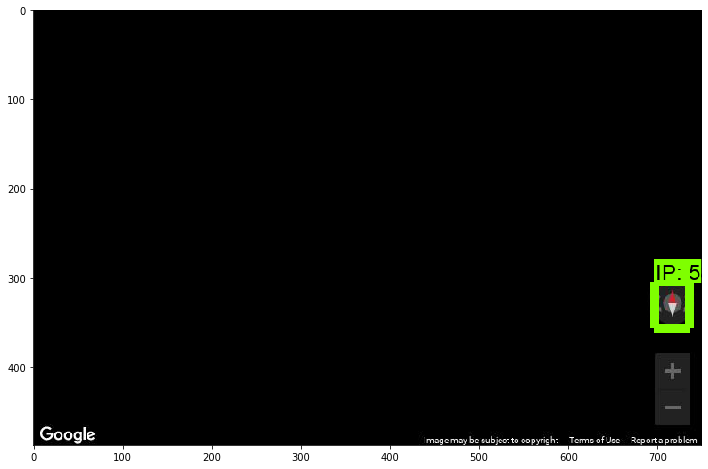

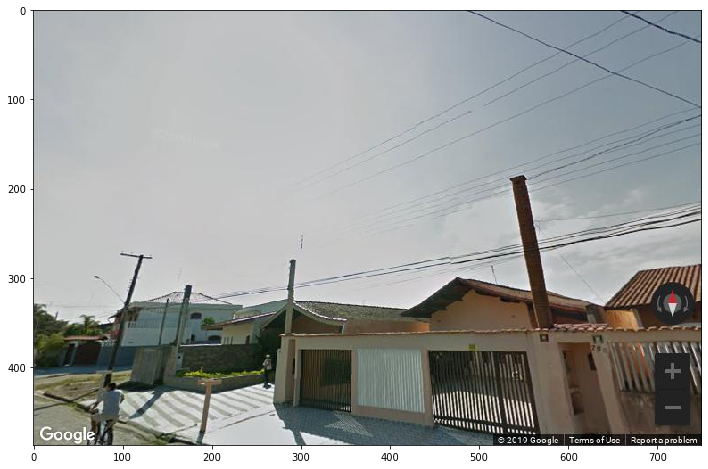

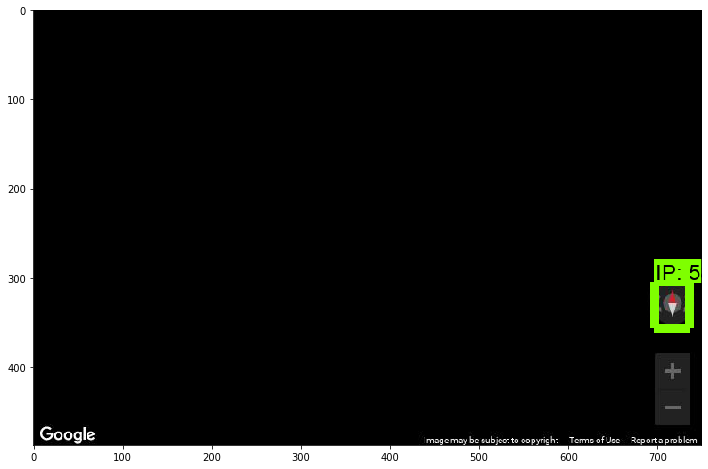

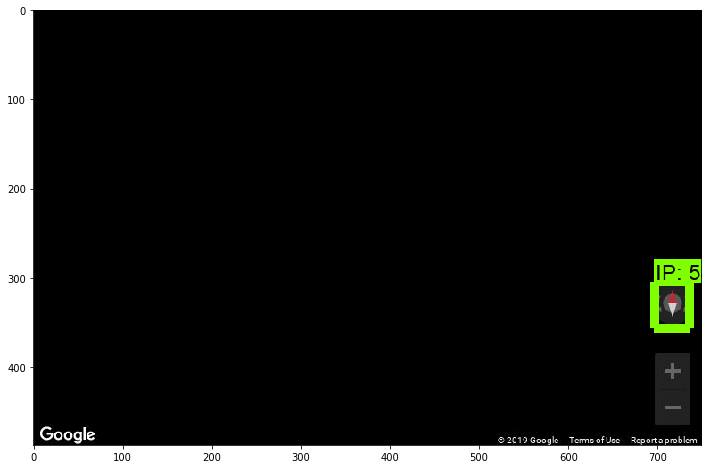

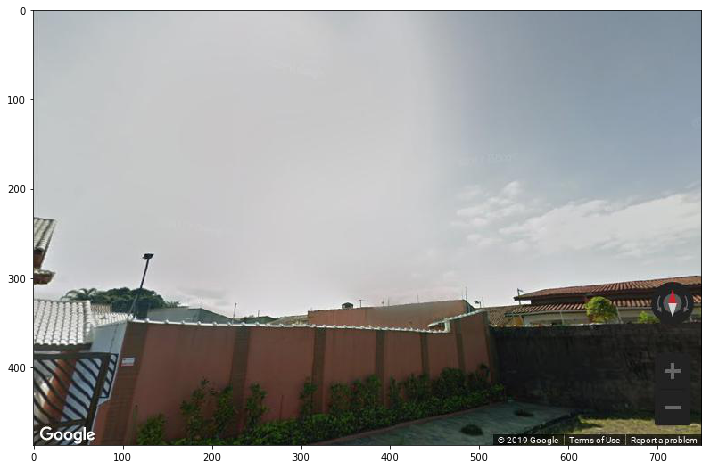

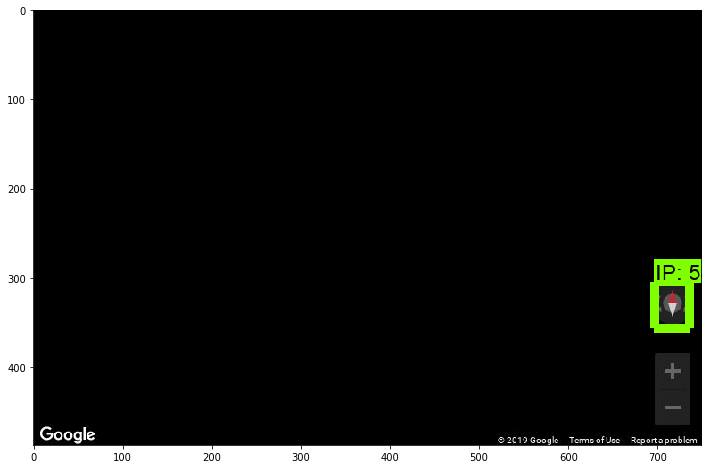

In [44]:
detect_and_classify_ip(URL_IMAGERY, True)

In [0]:
import pandas as pd

def create_analytics_dataframe(FILE_LAT_LONG):

analytics_dataframe = {}
  cidade = FILE_LAT_LOG['cidade']
    for item in URL_IMAGERY:
      analytics_dataframe = analytics_dataframe.append()
      response = detect_and_classify_ip(item)

    write.csv(analytics_dataframe, '/content/Respostas_Algoritmo.csv')
  return analytics_dataframe

